# 从phase1的数据中获取错误正确步骤对

In [3]:
import json
"""
process_jsonl 函数处理JSONL文件:

读取每行JSON数据
提取问题和步骤
对每个步骤判断是否有错误答案和正确答案
记录含有错误步骤的问题
output_results 函数将结果格式化为要求的输出格式

主流程会处理train和test两个文件

主要处理规则:

wrong_steps:

当chosen_completion为none且human_completion不为none时收集
从completions中选择rating为-1的text
如果没有错误步骤则为None
correct_step:

如果chosen_completion不为none,从completions中取对应index的text
否则如果human_completion不为none,取其text
两者都为none则跳过该步骤
只记录至少有一个错误步骤的问题

输出格式为每行一个JSON,包含problem和steps字段。
"""
def process_jsonl(filename):
    results = {}
    current_problem = None
    current_steps = []
    
    with open(filename, 'r') as f:
        for line in f:
            data = json.loads(line)
            
            # 获取问题
            if 'question' in data and 'problem' in data['question']:
                current_problem = data['question']['problem']
                current_steps = []
            
            # 处理每个步骤
            if 'label' in data and 'steps' in data['label']:
                for step in data['label']['steps']:
                    wrong_steps = []
                    correct_step = None
                    
                    # 判断是否有错误步骤
                    if step.get('chosen_completion') is None and step.get('human_completion') is not None:
                        # 获取错误步骤
                        for completion in step.get('completions', []):
                            if completion.get('rating') == -1:
                                wrong_steps.append(completion['text'])
                    
                    # 获取正确步骤
                    if step.get('chosen_completion') is not None:
                        idx = step['chosen_completion']
                        if step['completions'] and len(step['completions']) > idx:
                            correct_step = step['completions'][idx]['text']
                    elif step.get('human_completion') is not None:
                        correct_step = step['human_completion']['text']
                        
                    if correct_step is not None:
                        # 如果没有错误步骤用None代替
                        wrong_steps = wrong_steps if wrong_steps else None
                        current_steps.append((wrong_steps, correct_step))
                
                # 只记录有错误步骤的问题
                if current_problem and current_steps and any(step[0] for step in current_steps):
                    results[current_problem] = current_steps
    
    return results

def output_results(results, save_path):
    output = []
    for problem, steps in results.items():
        formatted = {
            "problem": problem,
            "steps": steps
        }
        output.append(json.dumps(formatted, ensure_ascii=False))
        
    with open(save_path, 'w') as f:
        f.write('\n'.join(output))
read_dir = '/zhuangkai/openo1/dataset/prm800k/data'
save_dir = '/zhuangkai/openo1/outputs/verifier'
# 使用示例
for stage in ['train', 'test']:
    save_path = f'{save_dir}/phase1_{stage}.jsonl'
    read_path = f'{read_dir}/phase1_{stage}.jsonl'
    results = process_jsonl(read_path)
    output_results(results, save_path)

In [5]:
"""
对outputs/verifier/phase1_{stage}.jsonl文件进行处理,生成correct_step的response，为了避免和终止step重合，每行最后一个step都不会生成response
"""

import json

def generate_verifier_response4correct_step(filename):
    output = []
    with open(filename, 'r') as f:
        for line in f:
            try:
                data = json.loads(line.strip())
                problem = data['problem']
                steps = data['steps']
                
                # 遍历除最后一个step外的所有steps
                for i in range(len(steps)-1):
                    current_step = steps[i][1]  # 获取当前correct step
                    previous_steps = []  # 收集之前的correct steps
                    
                    # 收集previous steps
                    for j in range(i):
                        previous_steps.append(steps[j][1])
                    
                    # 构造新格式的输出
                    formatted = {
                        "problem": problem,
                        "steps": {
                            "previous_steps": previous_steps,
                            "current_step": current_step,
                            "current_rating": 0,
                            "current_response": "Yes, continue"
                        }
                    }
                    output.append(formatted)
            
            except json.JSONDecodeError as e:
                print('error:', e)
                continue
                
    return output

def save_output(output, save_path):
    with open(save_path, 'w', encoding='utf-8') as f:
        for item in output:
            f.write(json.dumps(item, ensure_ascii=False) + '\n')

# 处理不同stage的文件
for stage in ['train', 'test']:
    filename = f'/zhuangkai/openo1/outputs/verifier/phase1_{stage}.jsonl'
    save_path = f'/zhuangkai/openo1/outputs/verifier/phase1_{stage}_correct.jsonl'
    output = generate_verifier_response4correct_step(filename)
    save_output(output, save_path)

In [1]:
"""
对dataset/prm800k/data/phase1_{stage}.jsonl文件进行处理，提取终止step，并生成response
"""
import json

def generate_verifier_response4termination_step(filename):
    results = []
    with open(filename, 'r') as f:
        for line in f:
            try:
                data = json.loads(line.strip())
                if 'question' in data and 'problem' in data['question'] and \
                   'label' in data and 'steps' in data['label'] and \
                   data['label']['finish_reason'] == "solution":
                    
                    problem = data['question']['problem']
                    current_steps = []
                    
                    # 获取所有correct steps
                    for step in data['label']['steps']:
                        correct_step = None
                        if step.get('chosen_completion') is not None:
                            idx = step['chosen_completion']
                            if step['completions'] and len(step['completions']) > idx:
                                correct_step = step['completions'][idx]['text']
                        elif step.get('human_completion') is not None:
                            correct_step = step['human_completion']['text']
                            
                        if correct_step is not None:
                            current_steps.append(correct_step)
                    
                    # 如果有steps，处理最后一个step
                    if current_steps:
                        formatted = {
                            "problem": problem,
                            "steps": {
                                "previous_steps": current_steps[:-1],
                                "current_step": current_steps[-1],
                                "current_rating": 1,
                                "current_response": "Yes, terminate"
                            }
                        }
                        results.append(formatted)
            
            except json.JSONDecodeError as e:
                print('error:', e)
                continue
                
    return results

stages = ['train', 'test']
read_dir = '/zhuangkai/openo1/dataset/prm800k/data'
save_dir = '/zhuangkai/openo1/outputs/verifier'

for stage in stages:
    read_path = f'{read_dir}/phase1_{stage}.jsonl'
    save_path = f'{save_dir}/phase1_{stage}_termination.jsonl'
    verifier_responses = generate_verifier_response4termination_step(read_path)
    
    # 保存结果
    with open(save_path, 'w', encoding='utf-8') as f:
        for item in verifier_responses:
            f.write(json.dumps(item, ensure_ascii=False) + '\n')

In [1]:
"""
要获得错误step的response，请运行以下指令
python scripts/create_verifier_dataset.py
"""

'\n要获得错误step的response，请运行以下指令\npython scripts/create_verifier_dataset.py\n'

In [2]:
import json

def merge_files(correct_path, wrong_path, termination_path, output_path):
    merged_results = []

    # 读取correct文件
    with open(correct_path, 'r') as f:
        for line in f:
            data = json.loads(line.strip())
            data['type'] = 'correct'
            merged_results.append(data)

    # 读取wrong文件
    with open(wrong_path, 'r') as f:
        for line in f:
            data = json.loads(line.strip())
            data['type'] = 'wrong'
            merged_results.append(data)

    # 读取termination文件
    with open(termination_path, 'r') as f:
        for line in f:
            data = json.loads(line.strip())
            data['type'] = 'termination'
            merged_results.append(data)

    # 保存合并后的文件
    with open(output_path, 'w', encoding='utf-8') as f:
        for item in merged_results:
            f.write(json.dumps(item, ensure_ascii=False) + '\n')

# 合并不同stage的文件
for stage in ['train', 'test']:
    correct_path = f'/zhuangkai/openo1/outputs/verifier/phase1_{stage}_correct.jsonl'
    wrong_path = f'/zhuangkai/openo1/outputs/verifier/phase1_{stage}_wrong.jsonl'
    termination_path = f'/zhuangkai/openo1/outputs/verifier/phase1_{stage}_termination.jsonl'
    output_path = f'/zhuangkai/openo1/outputs/verifier/phase1_{stage}_merged.jsonl'
    merge_files(correct_path, wrong_path, termination_path, output_path)

In [3]:
import random

def split_file(input_path, test_path, validation_path):
    with open(input_path, 'r') as f:
        lines = f.readlines()
    
    random.shuffle(lines)
    split_index = len(lines) // 2
    
    test_lines = lines[:split_index]
    validation_lines = lines[split_index:]
    
    with open(test_path, 'w') as f:
        f.writelines(test_lines)
    
    with open(validation_path, 'w') as f:
        f.writelines(validation_lines)

read_dir = '/zhuangkai/openo1/outputs/verifier'
save_dir = '/zhuangkai/openo1/dataset/prm800k/processed/verifier'
test_file_path = f'{read_dir}/phase1_test_merged.jsonl'
test_output_path = f'{save_dir}/phase1_test.jsonl'
validation_output_path = f'{save_dir}/phase1_validation.jsonl'

split_file(test_file_path, test_output_path, validation_output_path)

# 统计各个类型（correct,wrong,terminate）的数据有多少

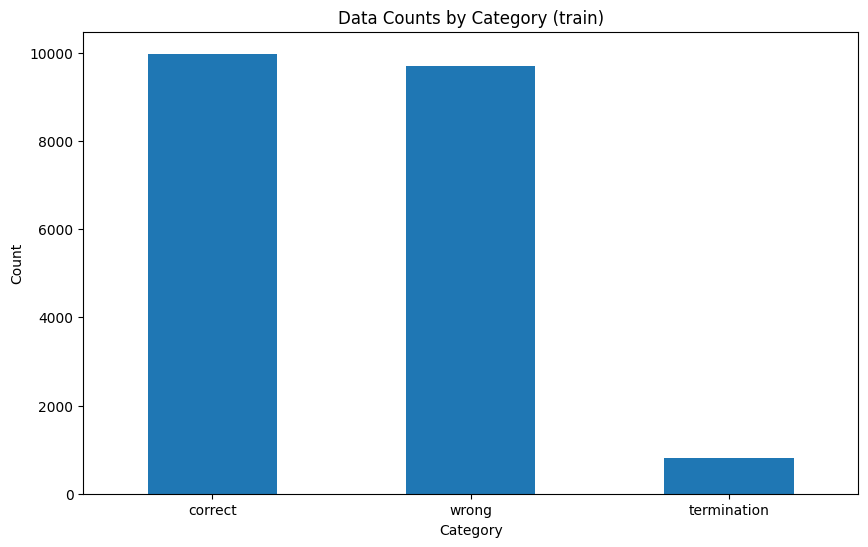

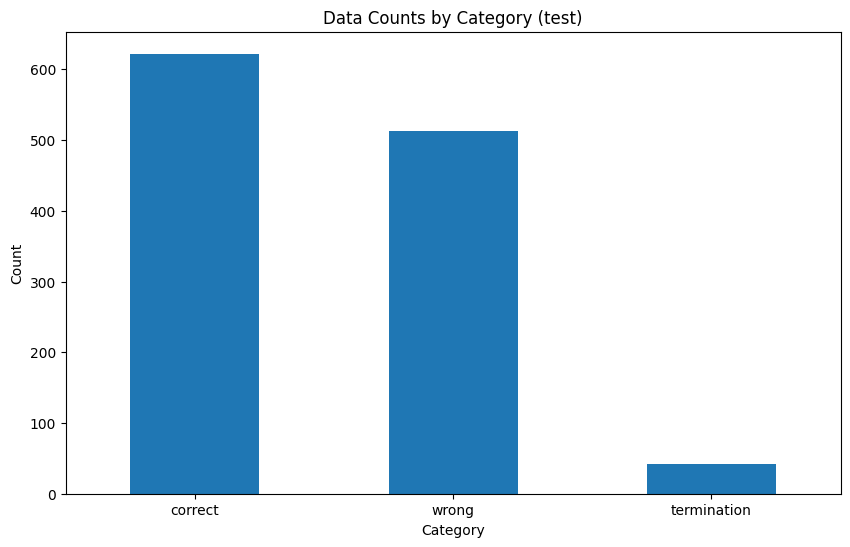

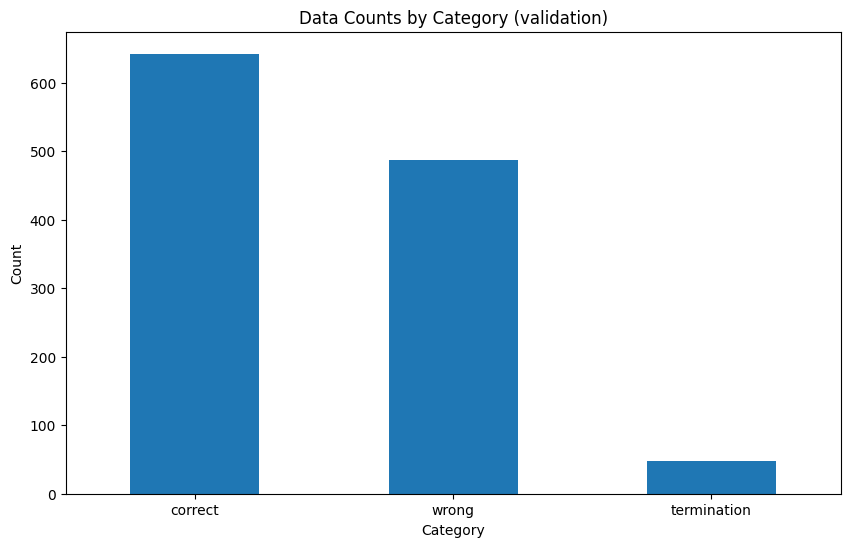

In [5]:
import pandas as pd

import matplotlib.pyplot as plt


# 读取不同阶段的文件并统计类别数量
for stage in ['train', 'test', 'validation']:
    file_path = f'/zhuangkai/openo1/dataset/prm800k/processed/verifier/phase1_{stage}.jsonl'
    data = []
    
    with open(file_path, 'r') as f:
        for line in f:
            data.append(json.loads(line.strip()))
    
    df = pd.DataFrame(data)
    category_counts = df['type'].value_counts()
    
    plt.figure(figsize=(10, 6))
    category_counts.plot(kind='bar')
    plt.title(f'Data Counts by Category ({stage})')
    plt.xlabel('Category')
    plt.ylabel('Count')
    plt.xticks(rotation=0)
    plt.show()

# 充分利用phase2阶段的数据

## 制作terminate类型数据

In [ ]:
import json

def generate_termination_responses(filename):
    results = []
    with open(filename, 'r') as f:
        for line in f:
            try:
                data = json.loads(line.strip())
                problem = data['problem']
                steps = data['steps']
                
                # Check if the last step has a rating of 1
                if steps and steps[-1][1] == 1:
                    previous_steps = [step[0] for step in steps[:-1]]
                    current_step = steps[-1][0]
                    
                    formatted = {
                        "problem": problem,
                        "steps": {
                            "previous_steps": previous_steps,
                            "current_step": current_step,
                            "current_rating": 1,
                            "current_response": "Yes, terminate"
                        }
                    }
                    results.append(formatted)
            
            except json.JSONDecodeError as e:
                print('error:', e)
                continue
                
    return results

# 处理不同stage的文件
stages = ['train', 'test']
read_dir = '/zhuangkai/openo1/outputs/rm'
save_dir = '/zhuangkai/openo1/outputs/verifier'

for stage in stages:
    filename = f'{read_dir}/phase2_{stage}_gt_pre_generated_solution.jsonl'
    termination_responses = generate_termination_responses(filename)
    save_path = f'{save_dir}/phase2_{stage}_termination.jsonl' 
    with open(save_path, 'w', encoding='utf-8') as f:
        for item in termination_responses:
            f.write(json.dumps(item, ensure_ascii=False) + '\n')

## 制作correct类型的数据

In [1]:
import json

def generate_correct_responses(filename):
    results = []
    with open(filename, 'r') as f:
        for line in f:
            try:
                data = json.loads(line.strip())
                problem = data['problem']
                steps = data['steps']
                
                # 遍历除最后一个step外的所有steps
                for i in range(len(steps) - 1):
                    current_step = steps[i][0]  # 获取当前correct step
                    previous_steps = []  # 收集之前的correct steps
                    
                    # 跳过第一个step如果它是错的
                    if i == 0 and steps[i][1] == -1:
                        continue
                    
                    # 收集previous steps
                    for j in range(i):
                        previous_steps.append(steps[j][0])
                    
                    # 构造新格式的输出
                    formatted = {
                        "problem": problem,
                        "steps": {
                            "previous_steps": previous_steps,
                            "current_step": current_step,
                            "current_rating": 0,
                            "current_response": "Yes, continue"
                        }
                    }
                    results.append(formatted)
            
            except json.JSONDecodeError as e:
                print('error:', e)
                continue
                
    return results

# 处理不同stage的文件
stages = ['train', 'test']
read_dir = '/zhuangkai/openo1/outputs/rm'
save_dir = '/zhuangkai/openo1/outputs/verifier'

for stage in stages:
    filename = f'{read_dir}/phase2_{stage}_gt_pre_generated_solution.jsonl'
    correct_responses = generate_correct_responses(filename)
    save_path = f'{save_dir}/phase2_{stage}_correct.jsonl' 
    with open(save_path, 'w', encoding='utf-8') as f:
        for item in correct_responses:
            f.write(json.dumps(item, ensure_ascii=False) + '\n')


In [ ]:
# 合并phase2不同类型的文件

def merge_files(correct_path, termination_path, output_path):
    merged_results = []

    # 读取correct文件
    with open(correct_path, 'r') as f:
        for line in f:
            data = json.loads(line.strip())
            data['type'] = 'correct'
            merged_results.append(data)

    # 读取termination文件
    with open(termination_path, 'r') as f:
        for line in f:
            data = json.loads(line.strip())
            data['type'] = 'termination'
            merged_results.append(data)

    # 保存合并后的文件
    with open(output_path, 'w', encoding='utf-8') as f:
        for item in merged_results:
            f.write(json.dumps(item, ensure_ascii=False) + '\n')

save_dir = '/zhuangkai/openo1/outputs/verifier'
# 合并phase2不同类型的文件
for stage in stages:
    correct_path = f'{save_dir}/phase2_{stage}_correct.jsonl'
    termination_path = f'{save_dir}/phase2_{stage}_termination.jsonl'
    output_path = f'{save_dir}/phase2_{stage}_merged.jsonl'
    merge_files(correct_path, termination_path, output_path)

In [3]:
def merge_phase1_and_phase2(phase1_path, phase2_path, output_path):
    merged_results = []

    # 读取phase1文件
    with open(phase1_path, 'r') as f:
        for line in f:
            data = json.loads(line.strip())
            merged_results.append(data)

    # 读取phase2文件
    with open(phase2_path, 'r') as f:
        for line in f:
            data = json.loads(line.strip())
            merged_results.append(data)

    # 保存合并后的文件
    with open(output_path, 'w', encoding='utf-8') as f:
        for item in merged_results:
            f.write(json.dumps(item, ensure_ascii=False) + '\n')

save_dir = '/zhuangkai/openo1/outputs/verifier'
# 合并phase1和phase2不同stage的文件
for stage in ['train', 'test']:
    phase1_path = f'{save_dir}/phase1_{stage}_merged.jsonl'
    phase2_path = f'{save_dir}/phase2_{stage}_merged.jsonl'
    output_path = f'{save_dir}/phase12_{stage}_merged.jsonl'
    merge_phase1_and_phase2(phase1_path, phase2_path, output_path)

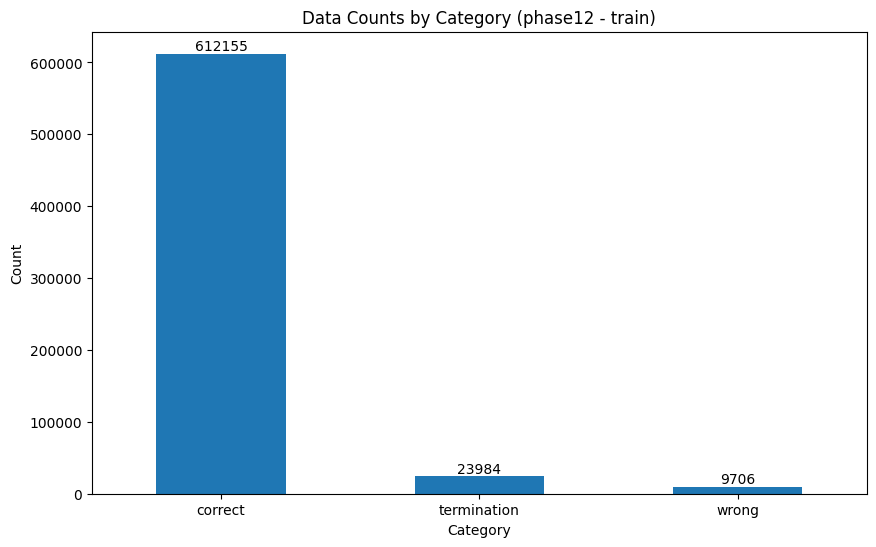

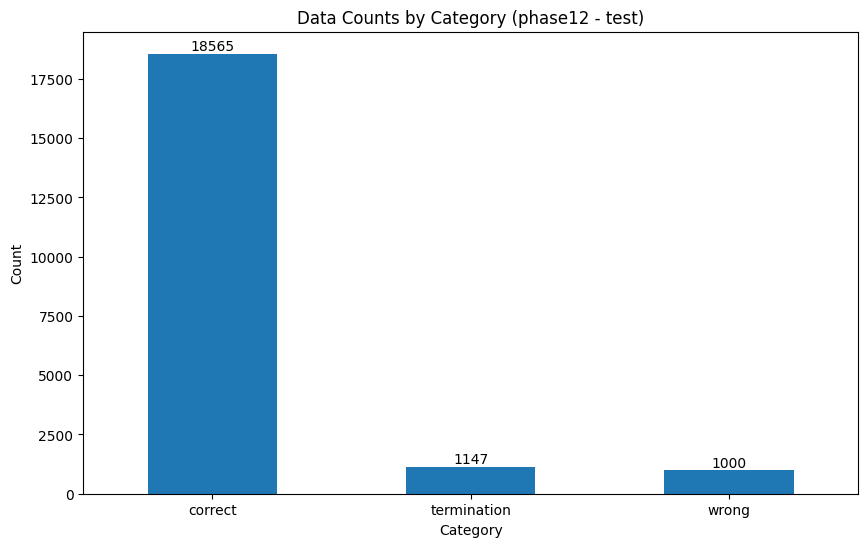

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# 读取不同阶段的文件并统计类别数量
for stage in ['train', 'test']:
    file_path = f'/zhuangkai/openo1/outputs/verifier/phase12_{stage}_merged.jsonl'
    data = []
    
    with open(file_path, 'r') as f:
        for line in f:
            data.append(json.loads(line.strip()))
    
    df = pd.DataFrame(data)
    category_counts = df['type'].value_counts()
    
    plt.figure(figsize=(10, 6))
    ax = category_counts.plot(kind='bar')
    plt.title(f'Data Counts by Category (phase12 - {stage})')
    plt.xlabel('Category')
    plt.ylabel('Count')
    plt.xticks(rotation=0)
    
    # 在柱状图上显示具体数量
    for i in ax.containers:
        ax.bar_label(i, label_type="edge")
    
    plt.show()

In [7]:
import random

def reduce_correct_data(df, scale):
    # 过滤出correct类型的数据
    correct_df = df[df['type'] == 'correct']
    other_df = df[df['type'] != 'correct']
    
    # 计算需要保留的correct数据数量
    retain_count = int(len(correct_df) * scale)
    
    # 随机选择需要保留的correct数据
    retained_correct_df = correct_df.sample(n=retain_count, random_state=42)
    
    # 合并保留的correct数据和其他类型的数据
    reduced_df = pd.concat([retained_correct_df, other_df])
    
    return reduced_df

# 设置删除比例
scale = 0.2  # 保留scale比例的correct数据

# 处理不同stage的文件
for stage in ['train', 'test']:
    file_path = f'/zhuangkai/openo1/outputs/verifier/phase12_{stage}_merged.jsonl'
    data = []

    with open(file_path, 'r') as f:
        for line in f:
            data.append(json.loads(line.strip()))

    df = pd.DataFrame(data)

    # 调用函数减少correct类型的数据
    reduced_df = reduce_correct_data(df, scale)

    # 保存减少后的数据
    output_path = f'/zhuangkai/openo1/outputs/verifier/phase12_{stage}_reduced.jsonl'
    with open(output_path, 'w', encoding='utf-8') as f:
        for item in reduced_df.to_dict(orient='records'):
            f.write(json.dumps(item, ensure_ascii=False) + '\n')

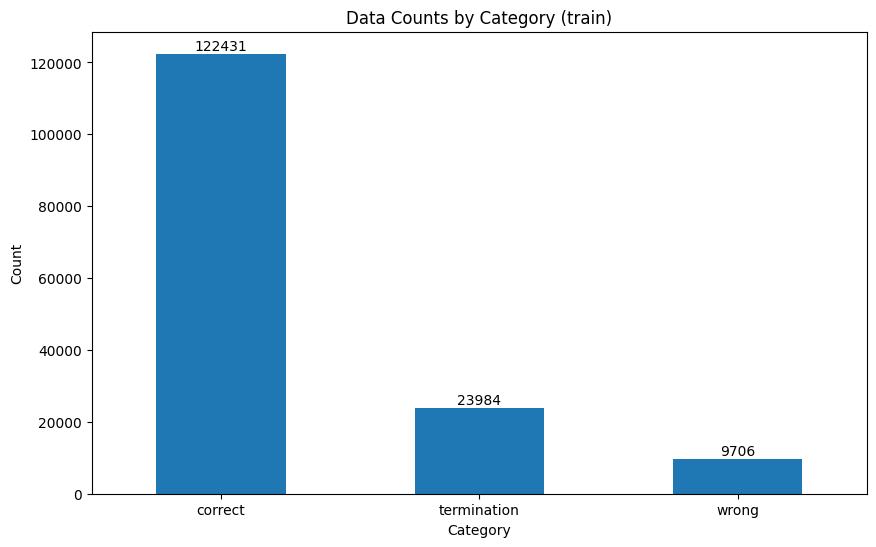

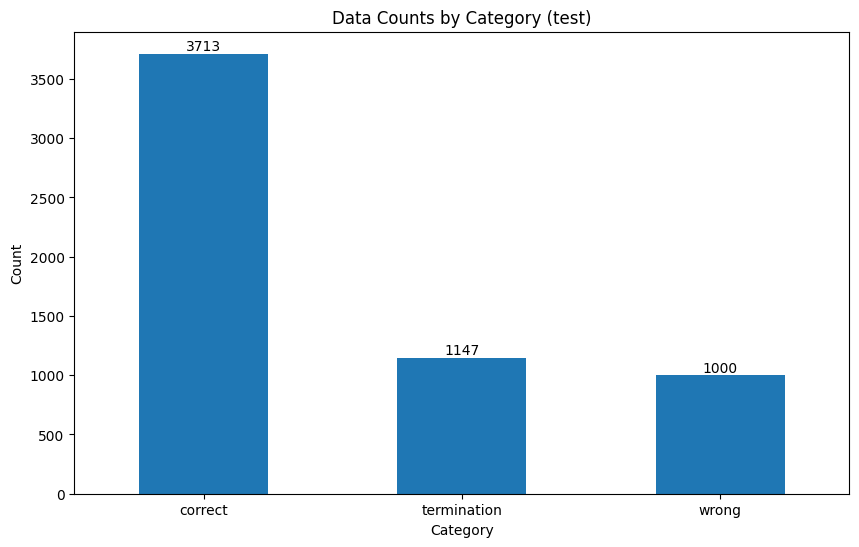

In [12]:
import pandas as pd

import matplotlib.pyplot as plt

# 读取不同阶段的文件并统计类别数量
for stage in ['train', 'test']:
    file_path = f'/zhuangkai/openo1/outputs/verifier/phase12_{stage}_reduced.jsonl'
    data = []
    
    with open(file_path, 'r') as f:
        for line in f:
            data.append(json.loads(line.strip()))
    
    df = pd.DataFrame(data)
    category_counts = df['type'].value_counts()
    
    plt.figure(figsize=(10, 6))
    ax = category_counts.plot(kind='bar')
    plt.title(f'Data Counts by Category ({stage})')
    plt.xlabel('Category')
    plt.ylabel('Count')
    plt.xticks(rotation=0)

    for i in ax.containers:
        ax.bar_label(i, label_type="edge")
        
    plt.show()

In [13]:
import random

def split_file(input_path, test_path, validation_path):
    with open(input_path, 'r') as f:
        lines = f.readlines()
    
    random.shuffle(lines)
    split_index = len(lines) // 2
    
    test_lines = lines[:split_index]
    validation_lines = lines[split_index:]
    
    with open(test_path, 'w') as f:
        f.writelines(test_lines)
    
    with open(validation_path, 'w') as f:
        f.writelines(validation_lines)

input_path = '/zhuangkai/openo1/outputs/verifier/phase12_test_reduced.jsonl'
test_output_path = '/zhuangkai/openo1/dataset/prm800k/processed/verifier/phase12_test.jsonl'
validation_output_path = '/zhuangkai/openo1/dataset/prm800k/processed/verifier/phase12_validation.jsonl'

split_file(input_path, test_output_path, validation_output_path)

645845it [00:07, 85133.56it/s] 
20712it [00:00, 87243.56it/s]


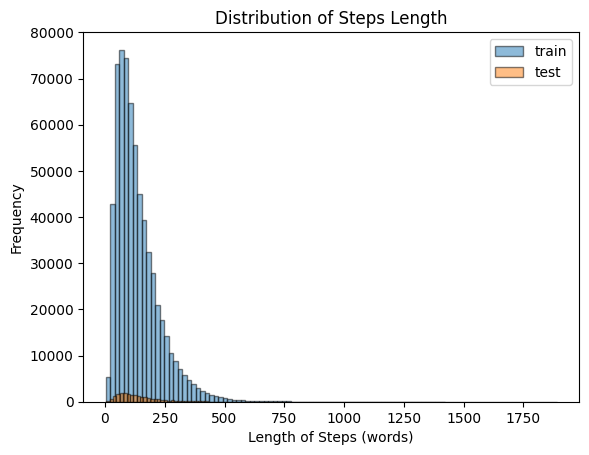

Stage: train
比例大于1024: 0.02%
比例大于2048: 0.00%
Stage: test
比例大于1024: 0.02%
比例大于2048: 0.00%


In [6]:
# 查看每个problem的steps的长度（以word为单位），并绘制分布图
# 分布图纵坐标是频率，横坐标是长度
# 各个stage的分布图放在一起
# 并分别统计长度大于1024与2048在各个stage的占比
import json
from tqdm import tqdm
import matplotlib.pyplot as plt

path = "/zhuangkai/openo1/outputs/verifier/phase12_{stage}_merged.jsonl"
for stage in ["train", "test"]:
    lengths = []
    count_gt_1024 = 0  # 统计长度大于1024的数量
    count_gt_2048 = 0  # 统计长度大于2048的数量
    total_count = 0     # 统计总数量
    with open(path.format(stage=stage), 'r', encoding='utf-8') as f:
        for line in tqdm(f):
            line = json.loads(line)
            problem = line["problem"]
            steps = line["steps"]
            previous_steps = steps["previous_steps"]
            current_step = steps["current_step"]
            # 将所有steps用空格来划分，以此统计数量
            length = len(" ".join([problem] + previous_steps + [current_step]).split(" "))
            lengths.append(length)
            total_count += 1  # 增加总数量
            if length > 1024:
                count_gt_1024 += 1  # 增加长度大于1024的计数
            if length > 2048:
                count_gt_2048 += 1  # 增加长度大于2048的计数

    plt.hist(lengths, bins=100, edgecolor='black', alpha=0.5, label=stage)

plt.xlabel('Length of Steps (words)')
plt.ylabel('Frequency')
plt.title('Distribution of Steps Length')
plt.legend()
plt.show()

# 输出长度大于1024与2048的占比
for stage in ["train", "test"]:
    print(f'Stage: {stage}')
    print(f'比例大于1024: {count_gt_1024 / total_count * 100:.2f}%')
    print(f'比例大于2048: {count_gt_2048 / total_count * 100:.2f}%')